# Controller #

Import all neccessary packages

In [1]:
import os
import pandas as pd
import numpy as np

from controllers.inference_controllers.sandbox import Sandbox
from controllers.inference_controllers.generator import Generator
from controllers.inference_controllers.optimiser import Optimiser

from toolboxes.plotting_toolbox.domain import Domain
from toolboxes.inference_toolbox.parameter import Parameter
from toolboxes.inference_toolbox.model import Model
from toolboxes.inference_toolbox.likelihood import Likelihood

current_directory = os.getcwd()
if current_directory != '/project/':
    os.chdir('/project/')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Defining simulated data

In [2]:
data_params = {
    'data_type': 'simulated_data',
    'model': {
        'model_select': 'log_gpm_norm',
        'model_params':{
            'H': 5
        },
        'inference_params':{
            'I_y': 1.6,
            'I_z': 1.2,
            'Q': 3e13,
            'sigma': 0.05
        }
    },
    'domain':{
        'domain_select': 'cone_from_source_z_limited',
        'domain_params': {
            'r': 1000,
            'theta': np.pi/8,
            'source': [0,0,10]
        },
        'resolution': 20
    },
    'noise_dist': 'gaussian',
    'noise_level': 0.05,
    'output_header': 'Concentration',
}

# data_params = {
#     'data_type': 'normalised_data',
#     'data_select': 'GBR_data',
#     'normaliser_select': 'GBR_normaliser',
#     'normaliser_params':{
#         'experiments_list': [
#             'Exp1',
#             'Exp2',
#             'Exp3',
#             'Exp4',
#             'Exp5',
#             'Exp6',
#             'Exp7',
#             'Exp8',
#             'Exp9',
#             'Exp10',
#             'Exp11',
#             'Exp12',
#         ],
#         'meta_data_select': 'GBR_data_summary',
#         'input_header': 'Concentration'
#     },
#     'log':True,
#     'output_header': 'Concentration',
#     'gridding': [100,100,25]
# }

prior_plots = [
    {
        'Q': [1e12, 5e13],
        'references':{
            'Q' : [2.82e13, 3.11e13, 2.89e13, 4.83e13],
            'labels': ['250m','200m','750m','1000m'] 
        }
    },
    # {
    #     'sigma': [0.001, 4],
    # },
    {
        'I_y': [0.0001, 1.7],
        'I_z': [0.0001, 1.7],
        'references':{
            'I_y' : [0.22, 1.6, 0.11, 0.08, 0.06, 0.04],
            'I_z' : [0.2, 1.2, 0.08, 0.06, 0.03, 0.016],
            'labels': ['A','B','C','D','E','F'] 
        }
    }
]

results_name = 'simulated_data_3'

Defining default parameters and prior plots for gamma priors of the simulated data

In [3]:
default_params = {
    'infered_params':pd.Series({
        'model_params':pd.Series({
            'I_y': Parameter('I_y', prior_select = 'log_norm', order = 1).add_prior_param('mu', 1.6).add_prior_param('cov',0.1),
            'I_z': Parameter('I_z', prior_select = 'log_norm', order = 1).add_prior_param('mu', 1.2).add_prior_param('cov',0.1),
            'Q': Parameter('Q', prior_select = 'log_norm', order = 1e13).add_prior_param('mu', 5).add_prior_param('cov',3.6),
            # 'I_y_and_I_z': Parameter('I_y','I_z', prior_select='log_norm', order = 1)
            #                         .add_prior_param('mu', [1.6,1.2])
            #                         .add_prior_param('cov', [[0.1,0],[0,0.1]]),

        }),
        'likelihood_params':pd.Series({
            # 'sigma': Parameter('sigma', prior_select = 'log_norm', order = 1).add_prior_param('mu', 5).add_prior_param('cov',5)
        })
    }),
    'model':Model('log_gpm_norm').add_model_param('H',5),
    'likelihood': Likelihood('gaussian_fixed_sigma').add_likelihood_param('sigma', 0.05),
    'sampler': {
        'n_warmup': 1,
        'n_samples': 100,
        'n_chains': 1,
        'thinning_rate': 1
    }
}

Running a general instance for gamma priors and simulated data

# NumPyro project template
Joshua Simmons 2023

This notebook is a base template for a NumPyro project. It contains the following:
- Basic imports
- Model definition example
- Prior predictive checks
- Inference example
- Posterior predictive checks
- Basic plotting functions

In [4]:
# General
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from tqdm import tqdm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

# NumPyro for proabilistic programming
import arviz as az
import jax
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive


# 2. Load or simulate the data

Here you can explain your data and how you load it.
For the template we will simulate some data.

In [5]:
sandbox = Sandbox(results_name=results_name, 
                  data_params=data_params,
                  default_params=default_params)

training_data, testing_data = sandbox.run()
# sandbox.sampler.test_priors()
training_data

x = jnp.array(training_data.x.values)
y = jnp.array(training_data.y.values)
z = jnp.array(training_data.z.values)

target = jnp.array(training_data.Concentration.values)
x.shape

(651,)

In [6]:
# General settings
ci = 0.89 # Credible interval (McElreath, 2018)


# 3. Define our model using NumPyro

We will fit our Bayesian Linear Regression using NumPyro. 
NumPyro is a probabilistic programming language which helps us to implement a sampling scheme for the paramaters in our model. You can read more about NumPyro [here](https://num.pyro.ai/en/stable/getting_started.html).

In [7]:
	
def linear_model(x,y,z,target=None):
    '''
    Model description: Linear regression model
    y = X*beta + epsilon
    '''
    I_y = numpyro.sample("I_y", dist.LogNormal(jnp.log(1.6), 0.1))
    I_z = numpyro.sample("I_z", dist.LogNormal(jnp.log(1.2), 0.1))
    Q = 3e13

    x = jnp.array(x)
    y = jnp.array(y)
    z = jnp.array(z)

    H = 5

    calc = jnp.log10(Q/(2*jnp.pi*I_y*I_z*x**2)*jnp.exp(-y**2/(2*I_y**2*x**2))*(jnp.exp(-(z-H)**2/(2*I_z**2*x**2))+jnp.exp(-(z+H)**2/(2*I_z**2*x**2))))

    mu = numpyro.deterministic("mu", calc)
    # sigma = 0.05
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(mu, sigma), obs=target)

In [8]:
H = 5.0

Q=3e13
I_y=2.2
I_z=1.2

target_2 = jnp.log10(Q/(2*jnp.pi*I_y*I_z*x**2)*jnp.exp(-y**2/(2*I_y**2*x**2))*(jnp.exp(-(z-H)**2/(2*I_z**2*x**2))+jnp.exp(-(z+H)**2/(2*I_z**2*x**2))))

H = 5

Q=3e13
I_y=1.6
I_z=1.2

target_3 = jnp.log10(Q/(2*jnp.pi*I_y*I_z*x**2)*jnp.exp(-y**2/(2*I_y**2*x**2))*(jnp.exp(-(z-H)**2/(2*I_z**2*x**2))+jnp.exp(-(z+H)**2/(2*I_z**2*x**2))))

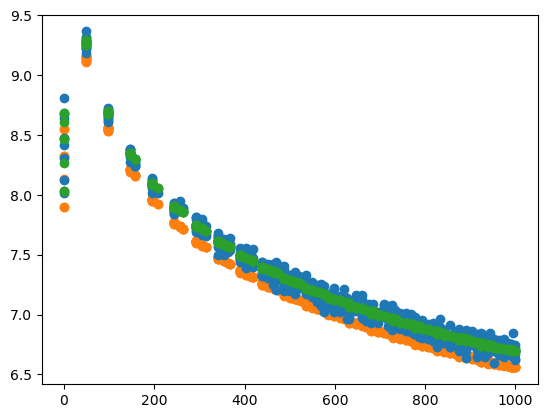

In [9]:
import matplotlib.pyplot as plt
plt.scatter(x, target_2, color='C1', label='True')
plt.scatter(x, target, color='C0', label='Observed')
plt.scatter(x, target_3, color='C2', label='True')

# 4. Prior checking
Now lets sample from out prior distributions, check what these look like with arviz. We will also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [10]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(linear_model, num_samples=500)(
    rng_key_, x=x, z=z, y=y
)

# and put this into arviz for easy plotting
arviz_priors = az.from_numpyro(
    prior=prior_samples
)

# get the mean model prediciton and CI
mean_mu_prior = jnp.mean(arviz_priors.prior['mu'].values.squeeze(), axis=0)
hpdi_mu_prior = hpdi(arviz_priors.prior['mu'].values.squeeze(), ci)
hpdi_sim_prior = hpdi(arviz_priors.prior['obs'].values.squeeze(), ci)

arviz_priors

Inference data with groups:
	> prior

################################################################################
Priors


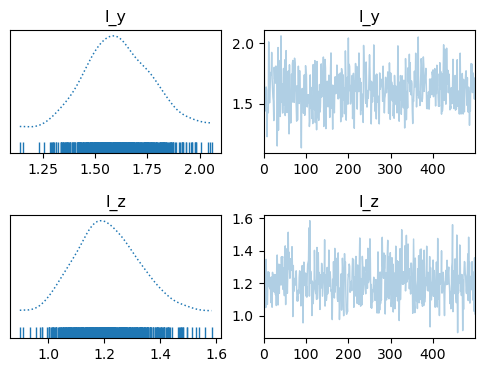

In [11]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_priors.prior, 
    var_names=['I_y','I_z'],
    figsize=(6,4),
    rug=True,
    combined=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

# 5. MCMC Sampling

We will use the No U-Turn Sampler (NUTS) to sample from our posterior distributions. This sampler is popular in many PPLs (Stan, pymc, pyro) and should do the job for us with our mere three parameters. We will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper.

Below is a generic setup that allows for the testing of multiple models via specifying `kernels_models`. 

In [12]:
# settings 
num_samples = 1000
num_warmup = 1000
num_chains = 4
max_tree = 10
save_bool = False # save to arviz netcdf
extract_vars = ['I_y','I_z','sigma','mu','obs'] # variables to extract from posterior_predictive
check_vars = [_ for _ in extract_vars if _ not in ['mu','obs']]

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS) for each model
# give a list with the NUTS sampler and the model
kernels_models = {
    'linear_model': [
        NUTS(
            linear_model,
            max_tree_depth=max_tree
        ),
        linear_model
    ]
}

# create storage
mcmc_outputs = {_: {} for _ in kernels_models.keys()}

for kern_name, this_kern in kernels_models.items():
    print('Running model: {}'.format(kern_name))
    # now run the sampler for num_samples+burnin
    mcmc_obj = MCMC(this_kern[0], num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_obj.run(
        rng_key_,
        x = x,
        y = y,
        z = z,
        target = target
    )

    # get the samples which will form our posterior
    samples = mcmc_obj.get_samples()

    # get the samples for predictive uncertainty (our linear model + error)
    posterior_predictive = Predictive(
        this_kern[1], posterior_samples=samples, 
        return_sites=extract_vars
    )(
        rng_key_, 
        x = x,
        y = y,
        z = z
    )

    # get named arvix object
    az_coords = {
        # "covariates": ["X{}".format(_) for _ in range(jnp_X.shape[1])],
    }
    az_dims = {
        # "beta": ["covariates"],
    }
    # create an arviz object
    arviz_posterior = az.from_numpyro(
        mcmc_obj,
        posterior_predictive=posterior_predictive,
        prior=prior_samples,
        coords=az_coords,
        dims=az_dims
    )

    # # get the mean model prediciton and use hpdi 
    # # to compute the credible intervals corresponding to ci
    # mean_mu, hpdi_mu, hpdi_sim = calc_mean_hpdi(
    #     arviz_posterior, ci=ci, y_scaler=scaler_y
    # )
    
    mcmc_outputs[kern_name] = {
        'arviz_posterior': arviz_posterior,
        # 'mean_mu': mean_mu,
        # 'hpdi_mu': hpdi_mu,
        # 'hpdi_sim': hpdi_sim
    }

Running model: linear_model


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## 5.1 MCMC Results
Plot the posterior distributions for our parameters and check for differences between the parameters for different groups. See poster for further discussion.

In [13]:

this_model = 'linear_model'
az.rhat(mcmc_outputs[this_model]['arviz_posterior'],var_names=check_vars)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    I_y      float64 1.0
    I_z      float64 1.001
    sigma    float64 1.002

################################################################################
Priors


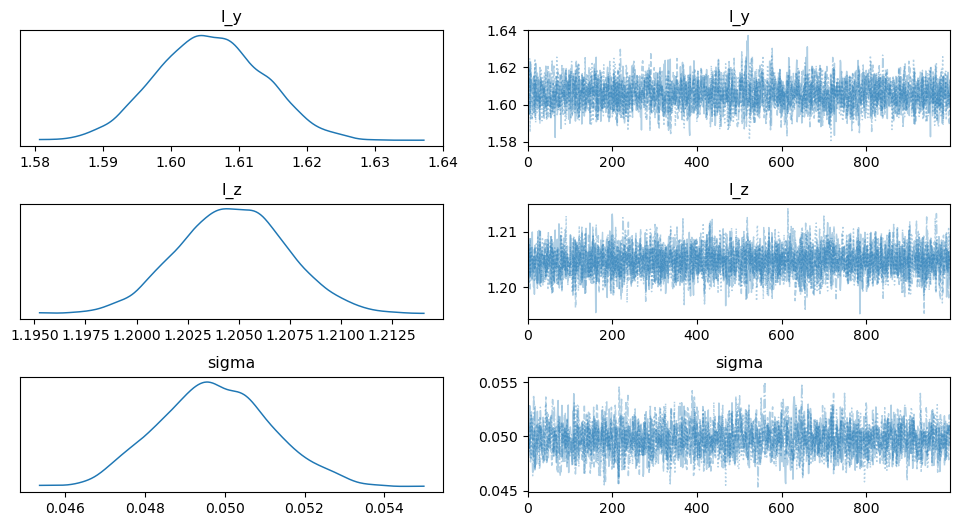

In [14]:
this_model = 'linear_model'
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    mcmc_outputs[this_model]['arviz_posterior'],
    var_names=check_vars,
    # r_hat = True,
    combined=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

################################################################################
Posterior


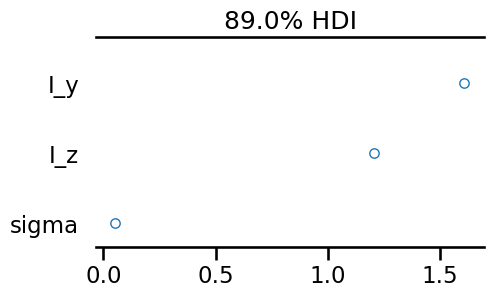

In [15]:
this_model = 'linear_model'
print('#'*80)
print('Posterior')
sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,6))
ax1 = plt.subplot(211)
az.plot_forest(
    mcmc_outputs[this_model]['arviz_posterior'],
    var_names=check_vars,
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
None

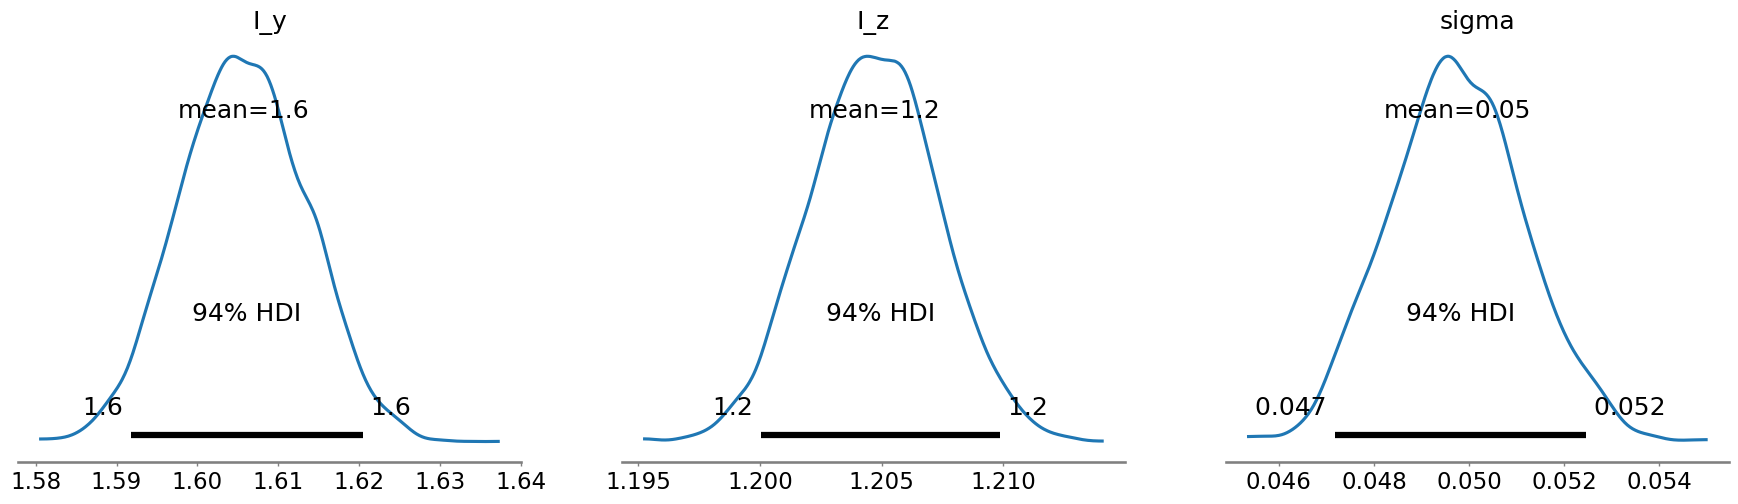

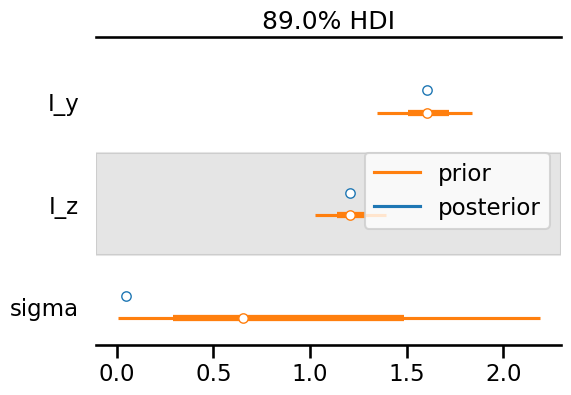

In [16]:
# Plot the posteriors
az.plot_posterior(mcmc_outputs[this_model]['arviz_posterior'], var_names=check_vars)
# Compare to priors
az.plot_forest(
    [
        mcmc_outputs[this_model]['arviz_posterior'].posterior,
        mcmc_outputs[this_model]['arviz_posterior'].prior
    ],
    combined=True,
    hdi_prob=ci,
    model_names=['posterior','prior'],
    var_names=check_vars,
    figsize=(6,4)
)
None